In [1]:
# 인공신경망관련 패키지
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

# 회귀분석 관련 패키지
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from xgboost import XGBRegressor


# 시각화 패키지
from matplotlib import pyplot as plt
import seaborn as sb

# 데이터 처리를 위한 패키지
import pandas as pd
import numpy as np
import math

# 다중공선성(multicollinearity) 처리를 위한VIF 확인 패키지
from statsmodels.stats.outliers_influence import variance_inflation_factor

# DeprecationWarning경고 무시
# 향후 안쓰일 함수들을 이용해서 만들어져 있기 때문에 필요하다 없으면, 사방이 붉어진다.
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

Using TensorFlow backend.
C:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
#########################################################################
# MAD 기반 예제코드
def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)
    modified_z_score = 0.6745 * diff / med_abs_deviation
    return modified_z_score > thresh 

# 출처: https://pythonanalysis.tistory.com/7 [Python 데이터 분석]
#########################################################################

# 소셜 데이터 처리를 위한 함수
# 1. 모든 소셜 데이터 column들의 첫번째는 : 날짜다.
# 2. 각 소셜데이터는 social_키워드.블로그/트위터/뉴스/총합 으로 되어 있다.
def changeColNames(d,before, after) : 
    # 컬럼이름 시리즈로 만들어 반환
    # 통합하기 쉽게, 모든 데이터들의 날짜컬럼 이름을 date로 통일
    new_col_names = ['date']
    new_col_names.extend(list(d.columns)[1:])
    d.columns = new_col_names
    return pd.Series(d.columns).apply(lambda x : x.replace(before,after))

#########################################################################
# modeling 함수로 만들어 처리하기
def linReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item, cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    model = LinearRegression().fit(X_train, y_train)
  
    print('LinearRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(model.score(X_train, y_train)))
    print('검증세트점수 : {:.2f}'.format(model.score(X_test, y_test)))

    
def ridgeReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item,cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    ridge = Ridge(alpha=0.1, normalize=True, random_state=0, tol=0.001).fit(X_train, y_train)
    
    print('RidgeRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(ridge.score(X_train, y_train)))
    print('검증세트점수 : {:.2f}'.format(ridge.score(X_test, y_test)))


def lassoReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item,cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    lasso = Lasso(alpha=0.1, max_iter=1000).fit(X=X_train, y=y_train)
  
    print('LassoRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(lasso.score(X_train, y_train)) )
    print('검증세트점수 : {:.2f}'.format(lasso.score(X_test, y_test)) )

    #사용한 특성수
    print('사용한 특성수 : {}'.format(np.sum(lasso.coef_ != 0)) )
#########################################################################

# 자료가 1일 1행이라는 전제하에
# df길이를 이용하여 날짜수를 계산, 이후 2016년 1월1일을 1번째주 1일이라 기준하에
# 몇번째 주인지 알려주는 컬럼 추가. 향후 주단위로 종합할때 스인다.
def addDayWeek(df):
    df_work = df.copy()
    df_work['day'] = pd.Series(range(1,df_work.shape[0]+1))
    df_work['week'] = df_work['day'].apply(lambda x : math.ceil(x/7))
    return df_work
#########################################################################
# 자료를 병합해주는 함수, 어떤 item인지 어느 컬럼을 기준으로 할지 받아서 병합
def mergeForAnalysis(df1, df2, df3, item, on_what='date'):
    merged_df = pd.merge(df1.loc[df1.category==item], df2, on=on_what, how='left')
    merged_df = pd.merge(merged_df, df3, on=on_what, how='left')
    return merged_df


#########################################################################
def lowVIF(df, n=7, cols_using =['temp', 'cloud', 'wind','humid', 'hpa', 'sun_time', 'lgt_time', 
       'SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25'] ):
    col_to_use = cols_using
    vif = pd.DataFrame()
    vif["VIF_Factor"] = [variance_inflation_factor(
        df[col_to_use].values, i) for i in range(df[col_to_use].shape[1])]
    vif["features"] = col_to_use
    vif.sort_values("VIF_Factor")
    lowest_vif = vif.sort_values("VIF_Factor")[:n].reset_index()
    lowest_vif.drop(columns='index', inplace=True)
    return lowest_vif

#########################################################################
# ols모델용 formula 생성
def formulaGen(target, ind_features):
    '''
    formulaGen(목표컬럼명,[변수컬럼명1, 변수컬럼명2,...])
    '''
    custom_formula = target + " ~ "
    for f in range(len(ind_features)):
        custom_formula += ind_features[f]
        if f!=(len(ind_features)-1):
            custom_formula += " + "
    return custom_formula


#########################################################################

In [3]:
# 데이터 불러오기 (전처리 된 GS, 랄라블라, 날씨)
gs = pd.read_csv('d:/project/contest/data/processed/p_gs.csv', parse_dates=['date'])
lv = pd.read_csv('d:/project/contest/data/processed/p_lavla.csv', parse_dates=['date'])
w = pd.read_csv('d:/project/contest/data/processed/p_wUVair_seoul.csv', parse_dates=['date'], index_col=0)
sns_all = pd.read_csv('d:/project/contest/data/processed/social_all.csv', parse_dates=['date'])

# GS/lv 서울시만
gs_seoul = gs.loc[gs.pvn_nm =='서울특별시']
lv_seoul = lv.loc[lv.pvn_nm =='서울특별시']
w_seoul = w.loc[w['loc']==108]

cols_to_keep = ['date','bor_nm','gender','age_cd','category','qty']

# 일일, 구단위, 상품별 판매량 종합
gs_grouped = gs_seoul[cols_to_keep].groupby(by=['date','bor_nm','category']).sum().reset_index()

# 일단위로 자료 종합(qty는 일일 합계)
day_gs_grouped = gs_grouped.groupby(by=['date','category']).sum().reset_index()

In [4]:
# '맥주'만 빼서 df생성
item = '맥주'
grouped_by = 'week'
day_gs_grouped_w_item = pd.merge(day_gs_grouped.loc[day_gs_grouped.category==item],w_seoul,on='date',how='left')
# day_gs_grouped_w_item.head(3)
day_gs_grouped_w_sns_item = pd.merge(day_gs_grouped_w_item, sns_all,on='date',how='left')

# 일단 uv = 자외선 지수는 결측치가 많아서 제외
selected_cols = ['date', 'category', 'qty', 'temp', 'rain', 'cloud', 'wind','humid', 'hpa',
                 'sun_time', 'lgt_time', 'snow',
                 'SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25',
                 'pm_blog', 'pm_twitter', 'pm_news', 'pm_total',
                 'health_blog', 'health_twitter', 'health_news', 'health_total',
                 'date_blog', 'date_twitter', 'date_news', 'date_total',
                 'br_blog', 'br_twitter', 'br_news', 'br_total',
                 'hobby_blog', 'hobby_twitter', 'hobby_news', 'hobby_total']
gs_day_w = day_gs_grouped_w_sns_item[selected_cols]

# 주단위로 종합해보기

In [5]:
gs_week_w = gs_day_w.copy()
gs_week_w = addDayWeek(gs_week_w)

cols_Ineed = ['week','category', 'qty', 'temp', 'rain', 'cloud', 'wind', 'humid','hpa', 'sun_time', 'lgt_time', 'snow',
              'SO2', 'CO', 'O3', 'NO2', 'PM10','PM25',
              'pm_blog', 'pm_twitter', 'pm_news', 'pm_total', 
              'health_blog','health_twitter', 'health_news', 'health_total',
              'date_blog','date_twitter', 'date_news', 'date_total',
              'br_blog', 'br_twitter','br_news', 'br_total',
              'hobby_blog', 'hobby_twitter', 'hobby_news','hobby_total']
gs_week_w = gs_week_w[cols_Ineed]

In [7]:
list_col = ['temp', 'rain', 'cloud', 'wind', 'humid','hpa', 'sun_time', 'lgt_time', 'snow',
              'SO2', 'CO', 'O3', 'NO2', 'PM10','PM25',
              'pm_blog', 'pm_twitter', 'pm_news', 'pm_total', 
              'health_blog','health_twitter', 'health_news', 'health_total',
              'date_blog','date_twitter', 'date_news', 'date_total',
              'br_blog', 'br_twitter','br_news', 'br_total',
              'hobby_blog', 'hobby_twitter', 'hobby_news','hobby_total']
lowVIF(gs_week_w,40,list_col)

list_col = ['temp', 'rain', 'cloud', 'wind', 'humid','hpa', 'sun_time', 'lgt_time', 'snow',
              'SO2', 'CO', 'O3', 'NO2', 'PM10','PM25',]
gs_week_w = gs_week_w[['week','qty']+list_col].groupby('week').mean().reset_index()
# gs_week_w.tail(2)

# week: 1~105 = 2016~2017년
# week: 106~157 = 2018년
train_data = gs_week_w.loc[gs_week_w.week <=105]
test_date = gs_week_w.loc[gs_week_w.week >105]

# 3년치 데이터 분리 : 종속변수('qty': 판매량)와 독립변수(판매량 제외 나머지 전부)
combined = gs_week_w.loc[:,'temp':'PM25']
target = gs_week_w.loc[:,'qty']

In [8]:
def get_cols_with_no_nans(df,col_type):
    '''
    Arguments :
    df : The dataframe to process
    col_type : 
          num : to only get numerical columns with no nans
          no_num : to only get nun-numerical columns with no nans
          all : to get any columns with no nans    
    '''
    if (col_type == 'num'):
        predictors = df.select_dtypes(exclude=['object'])
    elif (col_type == 'no_num'):
        predictors = df.select_dtypes(include=['object'])
    elif (col_type == 'all'):
        predictors = df
    else :
        print('Error : choose a type (num, no_num, all)')
        return 0
    cols_with_no_nans = []
    for col in predictors.columns:
        if not df[col].isnull().any():
            cols_with_no_nans.append(col)
    return cols_with_no_nans

In [9]:
num_cols = get_cols_with_no_nans(combined , 'num')
cat_cols = get_cols_with_no_nans(combined , 'no_num')

print ('Number of numerical columns with no nan values :',len(num_cols))
print ('Number of nun-numerical columns with no nan values :',len(cat_cols))

Number of numerical columns with no nan values : 15
Number of nun-numerical columns with no nan values : 0


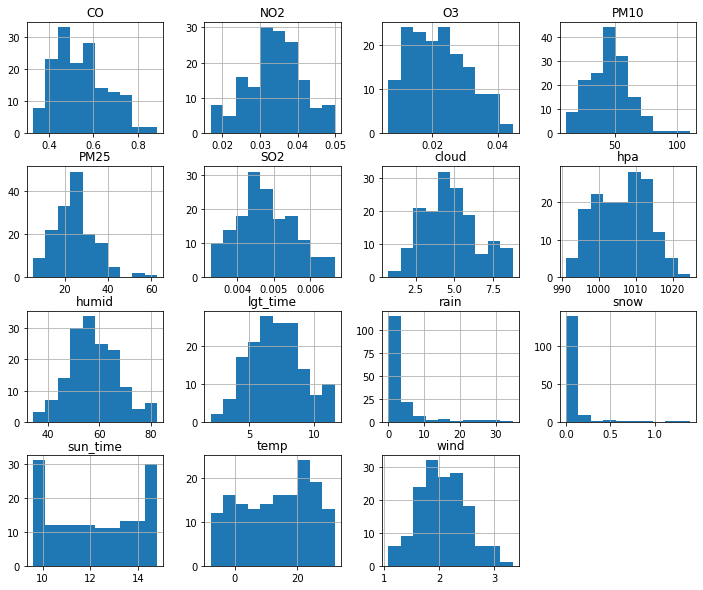

In [10]:
combined = combined[num_cols + cat_cols]
combined.hist(figsize = (12,10))
plt.show()

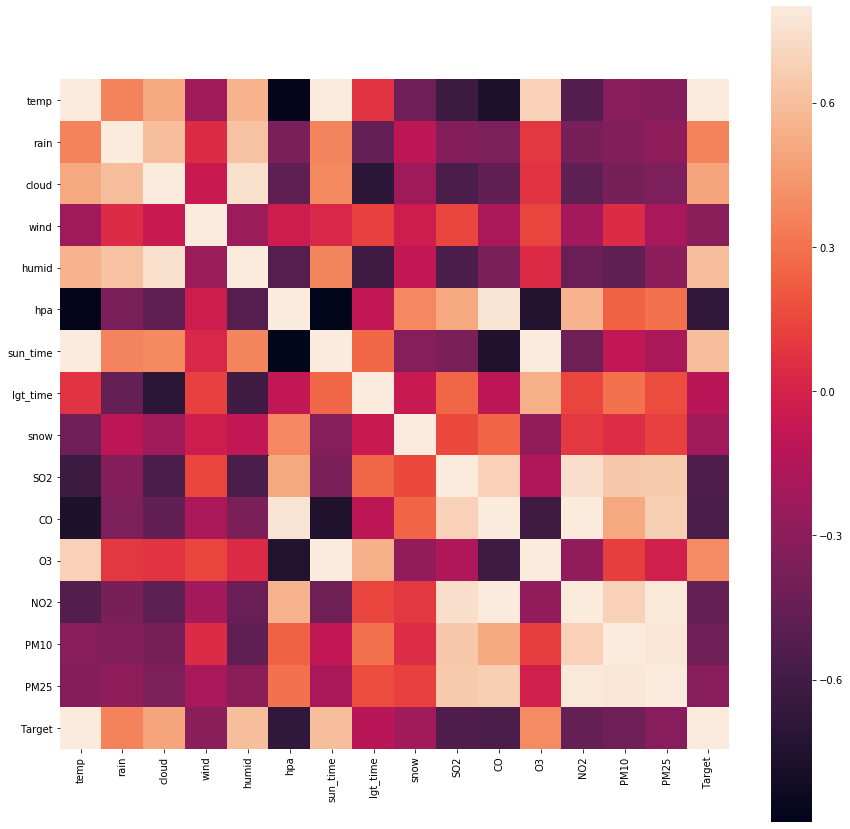

In [11]:
train_data = train_data[num_cols + cat_cols]
train_data['Target'] = target

C_mat = train_data.corr()
fig = plt.figure(figsize = (15,15))

sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()

In [12]:
def oneHotEncode(df,colNames):
    for col in colNames:
        if( df[col].dtype == np.dtype('object')):
            dummies = pd.get_dummies(df[col],prefix=col)
            df = pd.concat([df,dummies],axis=1)

            #drop the encoded column
            df.drop([col],axis = 1 , inplace=True)
    return df
    

print('There were {} columns before encoding categorical features'.format(combined.shape[1]))
combined = oneHotEncode(combined, cat_cols)
print('There are {} columns after encoding categorical features'.format(combined.shape[1]))

There were 15 columns before encoding categorical features
There are 15 columns after encoding categorical features


In [14]:
# 여기서 이코드으 제작자는 수동으로 훈련/검증셋을 나눔
# 105주 기준으로 나누겠음
cut_line = 106
def split_combined():
    global combined
    train = combined[:cut_line]
    test = combined[cut_line:]

    return train , test 
  
train, test = split_combined()
train.shape

(106, 15)

In [15]:
# 신경망 모델 생성
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
# optimizer에 여러 방식이 있다.
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

W0717 14:17:05.703342   224 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0717 14:17:05.719300   224 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0717 14:17:05.721295   224 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0717 14:17:05.780107   224 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               2048      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 166,913
Trainable params: 166,913
Non-trainable params: 0
_________________________________________________________________


In [16]:
# 인공 신경망에 의해 생성된 weight 자료를 저장하기 위해서
checkpoint_name = 'GS-'+item+grouped_by+'-Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 

# save_best_only값이 저장되어, 모든 weight값을 저장하지 않고, val_loss값이 줄어들때마다(적을수록 좋다.) 저장
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [17]:
# 예제에서는 target을 대회에서 주는 target데이터를 기준으로, 자료의 record수가 미리 train데이터와 맞춰졌있지만
# gs/lv데이터는 아니다. 그래서 위에서 나누는 기준으로 삼은cut_line=106을 이용하여 데이터 사이즈를 맞춰준다.
# 아니면 애시당초에(맨처음에) 훈련용 데이터와 타겟을 만들어 놓는것도 좋다.
NN_model.fit(train, target[:cut_line], epochs=500, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

W0717 14:17:23.786579   224 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0717 14:17:23.902265   224 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 84 samples, validate on 22 samples
Epoch 1/500
84/84 [==============================] - 0s 3ms/step - loss: 11607.9646 - mean_absolute_error: 11607.9646 - val_loss: 11365.7285 - val_mean_absolute_error: 11365.7285

Epoch 00001: val_loss improved from inf to 11365.72852, saving model to GS-맥주week-Weights-001--11365.72852.hdf5
Epoch 2/500
84/84 [==============================] - 0s 107us/step - loss: 11571.0030 - mean_absolute_error: 11571.0030 - val_loss: 11310.1826 - val_mean_absolute_error: 11310.1826

Epoch 00002: val_loss improved from 11365.72852 to 11310.18262, saving model to GS-맥주week-Weights-002--11310.18262.hdf5
Epoch 3/500
84/84 [==============================] - 0s 101us/step - loss: 11502.1039 - mean_absolute_error: 11502.1039 - val_loss: 11198.4131 - val_mean_absolute_error: 11198.4131

Epoch 00003: val_loss improved from 11310.18262 to 11198.41309, saving model to GS-맥주week-Weights-003--11198.41309.hdf5
Epoch 4/500
84/84 [==============================] - 0s 119u


Epoch 00031: val_loss improved from 1305.64795 to 1287.95520, saving model to GS-맥주week-Weights-031--1287.95520.hdf5
Epoch 32/500
84/84 [==============================] - 0s 107us/step - loss: 1769.3881 - mean_absolute_error: 1769.3881 - val_loss: 1284.3944 - val_mean_absolute_error: 1284.3944

Epoch 00032: val_loss improved from 1287.95520 to 1284.39441, saving model to GS-맥주week-Weights-032--1284.39441.hdf5
Epoch 33/500
84/84 [==============================] - 0s 202us/step - loss: 1757.4566 - mean_absolute_error: 1757.4566 - val_loss: 1279.6265 - val_mean_absolute_error: 1279.6265

Epoch 00033: val_loss improved from 1284.39441 to 1279.62646, saving model to GS-맥주week-Weights-033--1279.62646.hdf5
Epoch 34/500
84/84 [==============================] - 0s 202us/step - loss: 1756.0695 - mean_absolute_error: 1756.0695 - val_loss: 1260.0857 - val_mean_absolute_error: 1260.0857

Epoch 00034: val_loss improved from 1279.62646 to 1260.08569, saving model to GS-맥주week-Weights-034--1260.08569

Epoch 61/500
84/84 [==============================] - 0s 119us/step - loss: 1535.5428 - mean_absolute_error: 1535.5428 - val_loss: 963.9568 - val_mean_absolute_error: 963.9568

Epoch 00061: val_loss did not improve from 947.37659
Epoch 62/500
84/84 [==============================] - 0s 107us/step - loss: 1506.8813 - mean_absolute_error: 1506.8813 - val_loss: 922.6282 - val_mean_absolute_error: 922.6282

Epoch 00062: val_loss improved from 947.37659 to 922.62817, saving model to GS-맥주week-Weights-062--922.62817.hdf5
Epoch 63/500
84/84 [==============================] - 0s 142us/step - loss: 1502.1871 - mean_absolute_error: 1502.1871 - val_loss: 916.6059 - val_mean_absolute_error: 916.6059

Epoch 00063: val_loss improved from 922.62817 to 916.60590, saving model to GS-맥주week-Weights-063--916.60590.hdf5
Epoch 64/500
84/84 [==============================] - 0s 119us/step - loss: 1477.8108 - mean_absolute_error: 1477.8108 - val_loss: 901.0348 - val_mean_absolute_error: 901.0348

Epoch 00064

84/84 [==============================] - 0s 142us/step - loss: 1133.1428 - mean_absolute_error: 1133.1428 - val_loss: 692.3467 - val_mean_absolute_error: 692.3467

Epoch 00092: val_loss did not improve from 531.43152
Epoch 93/500
84/84 [==============================] - 0s 119us/step - loss: 1126.4961 - mean_absolute_error: 1126.4961 - val_loss: 641.0479 - val_mean_absolute_error: 641.0479

Epoch 00093: val_loss did not improve from 531.43152
Epoch 94/500
84/84 [==============================] - 0s 95us/step - loss: 1117.4719 - mean_absolute_error: 1117.4719 - val_loss: 637.7095 - val_mean_absolute_error: 637.7095

Epoch 00094: val_loss did not improve from 531.43152
Epoch 95/500
84/84 [==============================] - 0s 142us/step - loss: 1117.2540 - mean_absolute_error: 1117.2540 - val_loss: 514.3788 - val_mean_absolute_error: 514.3788

Epoch 00095: val_loss improved from 531.43152 to 514.37885, saving model to GS-맥주week-Weights-095--514.37885.hdf5
Epoch 96/500
84/84 [=============

84/84 [==============================] - 0s 131us/step - loss: 1005.2255 - mean_absolute_error: 1005.2255 - val_loss: 522.7722 - val_mean_absolute_error: 522.7722

Epoch 00126: val_loss did not improve from 420.76282
Epoch 127/500
84/84 [==============================] - 0s 107us/step - loss: 976.0813 - mean_absolute_error: 976.0813 - val_loss: 463.8274 - val_mean_absolute_error: 463.8274

Epoch 00127: val_loss did not improve from 420.76282
Epoch 128/500
84/84 [==============================] - 0s 107us/step - loss: 964.3258 - mean_absolute_error: 964.3258 - val_loss: 593.1700 - val_mean_absolute_error: 593.1700

Epoch 00128: val_loss did not improve from 420.76282
Epoch 129/500
84/84 [==============================] - 0s 119us/step - loss: 954.0844 - mean_absolute_error: 954.0844 - val_loss: 579.0374 - val_mean_absolute_error: 579.0374

Epoch 00129: val_loss did not improve from 420.76282
Epoch 130/500
84/84 [==============================] - 0s 131us/step - loss: 954.3991 - mean_abs

84/84 [==============================] - 0s 107us/step - loss: 894.8043 - mean_absolute_error: 894.8043 - val_loss: 537.9188 - val_mean_absolute_error: 537.9188

Epoch 00161: val_loss did not improve from 374.37149
Epoch 162/500
84/84 [==============================] - 0s 142us/step - loss: 898.4750 - mean_absolute_error: 898.4750 - val_loss: 435.5747 - val_mean_absolute_error: 435.5747

Epoch 00162: val_loss did not improve from 374.37149
Epoch 163/500
84/84 [==============================] - 0s 107us/step - loss: 894.9935 - mean_absolute_error: 894.9935 - val_loss: 601.0865 - val_mean_absolute_error: 601.0865

Epoch 00163: val_loss did not improve from 374.37149
Epoch 164/500
84/84 [==============================] - 0s 107us/step - loss: 909.6656 - mean_absolute_error: 909.6656 - val_loss: 458.4161 - val_mean_absolute_error: 458.4161

Epoch 00164: val_loss did not improve from 374.37149
Epoch 165/500
84/84 [==============================] - 0s 131us/step - loss: 892.2169 - mean_absol

84/84 [==============================] - 0s 142us/step - loss: 907.2520 - mean_absolute_error: 907.2520 - val_loss: 644.4510 - val_mean_absolute_error: 644.4510

Epoch 00196: val_loss did not improve from 323.13028
Epoch 197/500
84/84 [==============================] - 0s 154us/step - loss: 893.7507 - mean_absolute_error: 893.7507 - val_loss: 331.9363 - val_mean_absolute_error: 331.9363

Epoch 00197: val_loss did not improve from 323.13028
Epoch 198/500
84/84 [==============================] - 0s 131us/step - loss: 955.7780 - mean_absolute_error: 955.7780 - val_loss: 441.5792 - val_mean_absolute_error: 441.5792

Epoch 00198: val_loss did not improve from 323.13028
Epoch 199/500
84/84 [==============================] - 0s 119us/step - loss: 948.2772 - mean_absolute_error: 948.2772 - val_loss: 662.1915 - val_mean_absolute_error: 662.1915

Epoch 00199: val_loss did not improve from 323.13028
Epoch 200/500
84/84 [==============================] - 0s 142us/step - loss: 928.4829 - mean_absol

Epoch 232/500
84/84 [==============================] - 0s 142us/step - loss: 901.5689 - mean_absolute_error: 901.5689 - val_loss: 590.6324 - val_mean_absolute_error: 590.6324

Epoch 00232: val_loss did not improve from 320.24689
Epoch 233/500
84/84 [==============================] - 0s 95us/step - loss: 880.6293 - mean_absolute_error: 880.6293 - val_loss: 319.6460 - val_mean_absolute_error: 319.6460

Epoch 00233: val_loss improved from 320.24689 to 319.64597, saving model to GS-맥주week-Weights-233--319.64597.hdf5
Epoch 234/500
84/84 [==============================] - 0s 119us/step - loss: 949.9630 - mean_absolute_error: 949.9630 - val_loss: 364.3463 - val_mean_absolute_error: 364.3463

Epoch 00234: val_loss did not improve from 319.64597
Epoch 235/500
84/84 [==============================] - 0s 107us/step - loss: 924.8041 - mean_absolute_error: 924.8041 - val_loss: 521.4958 - val_mean_absolute_error: 521.4958

Epoch 00235: val_loss did not improve from 319.64597
Epoch 236/500
84/84 [===


Epoch 00267: val_loss did not improve from 319.64597
Epoch 268/500
84/84 [==============================] - 0s 142us/step - loss: 870.2232 - mean_absolute_error: 870.2232 - val_loss: 408.0796 - val_mean_absolute_error: 408.0796

Epoch 00268: val_loss did not improve from 319.64597
Epoch 269/500
84/84 [==============================] - 0s 142us/step - loss: 867.3435 - mean_absolute_error: 867.3435 - val_loss: 386.5615 - val_mean_absolute_error: 386.5615

Epoch 00269: val_loss did not improve from 319.64597
Epoch 270/500
84/84 [==============================] - 0s 119us/step - loss: 864.1951 - mean_absolute_error: 864.1951 - val_loss: 350.7671 - val_mean_absolute_error: 350.7671

Epoch 00270: val_loss did not improve from 319.64597
Epoch 271/500
84/84 [==============================] - 0s 119us/step - loss: 870.0888 - mean_absolute_error: 870.0888 - val_loss: 392.7777 - val_mean_absolute_error: 392.7777

Epoch 00271: val_loss did not improve from 319.64597
Epoch 272/500
84/84 [=========

84/84 [==============================] - 0s 119us/step - loss: 878.8534 - mean_absolute_error: 878.8534 - val_loss: 326.2852 - val_mean_absolute_error: 326.2852

Epoch 00303: val_loss did not improve from 311.74405
Epoch 304/500
84/84 [==============================] - 0s 107us/step - loss: 935.1908 - mean_absolute_error: 935.1908 - val_loss: 486.3672 - val_mean_absolute_error: 486.3672

Epoch 00304: val_loss did not improve from 311.74405
Epoch 305/500
84/84 [==============================] - 0s 107us/step - loss: 918.5858 - mean_absolute_error: 918.5858 - val_loss: 383.8991 - val_mean_absolute_error: 383.8991

Epoch 00305: val_loss did not improve from 311.74405
Epoch 306/500
84/84 [==============================] - 0s 142us/step - loss: 934.6793 - mean_absolute_error: 934.6793 - val_loss: 322.1295 - val_mean_absolute_error: 322.1295

Epoch 00306: val_loss did not improve from 311.74405
Epoch 307/500
84/84 [==============================] - 0s 131us/step - loss: 902.9474 - mean_absol

84/84 [==============================] - 0s 119us/step - loss: 866.2683 - mean_absolute_error: 866.2683 - val_loss: 369.4539 - val_mean_absolute_error: 369.4539

Epoch 00339: val_loss did not improve from 311.74405
Epoch 340/500
84/84 [==============================] - 0s 131us/step - loss: 927.4691 - mean_absolute_error: 927.4691 - val_loss: 392.2635 - val_mean_absolute_error: 392.2635

Epoch 00340: val_loss did not improve from 311.74405
Epoch 341/500
84/84 [==============================] - 0s 142us/step - loss: 866.7430 - mean_absolute_error: 866.7430 - val_loss: 374.1823 - val_mean_absolute_error: 374.1823

Epoch 00341: val_loss did not improve from 311.74405
Epoch 342/500
84/84 [==============================] - 0s 125us/step - loss: 867.9309 - mean_absolute_error: 867.9309 - val_loss: 333.8405 - val_mean_absolute_error: 333.8405

Epoch 00342: val_loss did not improve from 311.74405
Epoch 343/500
84/84 [==============================] - 0s 119us/step - loss: 876.3784 - mean_absol

84/84 [==============================] - 0s 131us/step - loss: 901.3438 - mean_absolute_error: 901.3438 - val_loss: 321.1591 - val_mean_absolute_error: 321.1591

Epoch 00375: val_loss did not improve from 311.74405
Epoch 376/500
84/84 [==============================] - 0s 119us/step - loss: 898.8161 - mean_absolute_error: 898.8161 - val_loss: 357.2707 - val_mean_absolute_error: 357.2707

Epoch 00376: val_loss did not improve from 311.74405
Epoch 377/500
84/84 [==============================] - 0s 142us/step - loss: 896.7982 - mean_absolute_error: 896.7982 - val_loss: 467.1440 - val_mean_absolute_error: 467.1440

Epoch 00377: val_loss did not improve from 311.74405
Epoch 378/500
84/84 [==============================] - 0s 154us/step - loss: 926.7460 - mean_absolute_error: 926.7460 - val_loss: 327.1069 - val_mean_absolute_error: 327.1069

Epoch 00378: val_loss did not improve from 311.74405
Epoch 379/500
84/84 [==============================] - 0s 142us/step - loss: 885.8654 - mean_absol

84/84 [==============================] - 0s 131us/step - loss: 858.5207 - mean_absolute_error: 858.5207 - val_loss: 341.0666 - val_mean_absolute_error: 341.0666

Epoch 00411: val_loss did not improve from 311.74405
Epoch 412/500
84/84 [==============================] - 0s 131us/step - loss: 876.7213 - mean_absolute_error: 876.7213 - val_loss: 345.3445 - val_mean_absolute_error: 345.3445

Epoch 00412: val_loss did not improve from 311.74405
Epoch 413/500
84/84 [==============================] - 0s 131us/step - loss: 906.1978 - mean_absolute_error: 906.1978 - val_loss: 453.0848 - val_mean_absolute_error: 453.0848

Epoch 00413: val_loss did not improve from 311.74405
Epoch 414/500
84/84 [==============================] - 0s 119us/step - loss: 871.2546 - mean_absolute_error: 871.2546 - val_loss: 321.0049 - val_mean_absolute_error: 321.0049

Epoch 00414: val_loss did not improve from 311.74405
Epoch 415/500
84/84 [==============================] - 0s 131us/step - loss: 854.6603 - mean_absol

84/84 [==============================] - 0s 131us/step - loss: 866.3700 - mean_absolute_error: 866.3700 - val_loss: 432.6904 - val_mean_absolute_error: 432.6904

Epoch 00447: val_loss did not improve from 311.74405
Epoch 448/500
84/84 [==============================] - 0s 166us/step - loss: 836.1350 - mean_absolute_error: 836.1350 - val_loss: 323.2630 - val_mean_absolute_error: 323.2630

Epoch 00448: val_loss did not improve from 311.74405
Epoch 449/500
84/84 [==============================] - 0s 142us/step - loss: 900.7866 - mean_absolute_error: 900.7866 - val_loss: 479.9714 - val_mean_absolute_error: 479.9714

Epoch 00449: val_loss did not improve from 311.74405
Epoch 450/500
84/84 [==============================] - 0s 131us/step - loss: 881.1473 - mean_absolute_error: 881.1473 - val_loss: 340.3212 - val_mean_absolute_error: 340.3212

Epoch 00450: val_loss did not improve from 311.74405
Epoch 451/500
84/84 [==============================] - 0s 131us/step - loss: 862.1838 - mean_absol


Epoch 00482: val_loss did not improve from 311.74405
Epoch 483/500
84/84 [==============================] - 0s 131us/step - loss: 839.0014 - mean_absolute_error: 839.0014 - val_loss: 332.4959 - val_mean_absolute_error: 332.4959

Epoch 00483: val_loss did not improve from 311.74405
Epoch 484/500
84/84 [==============================] - 0s 119us/step - loss: 867.5136 - mean_absolute_error: 867.5136 - val_loss: 494.7445 - val_mean_absolute_error: 494.7445

Epoch 00484: val_loss did not improve from 311.74405
Epoch 485/500
84/84 [==============================] - 0s 166us/step - loss: 874.4393 - mean_absolute_error: 874.4393 - val_loss: 323.7246 - val_mean_absolute_error: 323.7246

Epoch 00485: val_loss did not improve from 311.74405
Epoch 486/500
84/84 [==============================] - 0s 166us/step - loss: 882.9092 - mean_absolute_error: 882.9092 - val_loss: 370.3804 - val_mean_absolute_error: 370.3804

Epoch 00486: val_loss did not improve from 311.74405
Epoch 487/500
84/84 [=========

In [18]:
# 500번을 학습하여 나온 결과들중, 가장 좋은(마지막에 저장된) Weights파일을 가져온다.
# Load wights file of the best model :
wights_file = 'GS-맥주week-Weights-286--311.74405.hdf5' # choose the best checkpoint 
NN_model.load_weights(wights_file) # load it
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

In [19]:
# rf나,XGB회귀 분석을위한 훈련/검증 dataset생산
train_X, val_X, train_y, val_y = train_test_split(train, target[:cut_line], test_size = 0.25, random_state = 14)

In [20]:
# RandomForest 회귀분석
model = RandomForestRegressor()
model.fit(train_X,train_y)

# Get the mean absolute error on the validation data
RFpredicted = model.predict(val_X)
MAE = mean_absolute_error(val_y , RFpredicted)
print('Random forest validation MAE = ', MAE)

Random forest validation MAE =  1025.1698412698408


In [24]:
# XGBRegressor 회귀분석
XGBModel = XGBRegressor()
XGBModel.fit(train_X,train_y , verbose=False)

# Get the mean absolute error on the validation data :
XGBpredictions = XGBModel.predict(val_X)
MAE = mean_absolute_error(val_y , XGBpredictions)
print('XGBoost validation MAE = ',MAE)

[14:19:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost validation MAE =  956.0594153025794


In [28]:
combined = gs_week_w.loc[:,'temp':'PM25']
target = gs_week_w.loc[:,'qty']

# 가장 좋다고 판명된 설정을 이용하여, 예측qty생산
predictions = NN_model.predict(combined)

# RandomForest 회귀분석 예측 qty생산
RFpredicted = model.predict(combined)
# XGBRegressor 회귀분석 예측 qty생산
XGBpredictions = XGBModel.predict(combined)

result_df = pd.DataFrame()
result_df['week'] = gs_week_w['week']
result_df['qty'] = gs_week_w.loc[:,'qty']

print("keras 신경망 predictions",predictions.shape)
result_df['keras_qty'] = predictions

print("randomforest 예상",RFpredicted.shape)
result_df['rf_qty'] = RFpredicted

print("XGBpredictions",XGBpredictions.shape)
result_df['xgb_qty'] = XGBpredictions

keras 신경망 predictions (157, 1)
randomforest 예상 (157,)
XGBpredictions (157,)


In [29]:
df_graph = result_df.loc[:,['week','keras_qty','rf_qty','xgb_qty','qty']]
df_graph['week'] = pd.to_datetime(df_graph['week'])

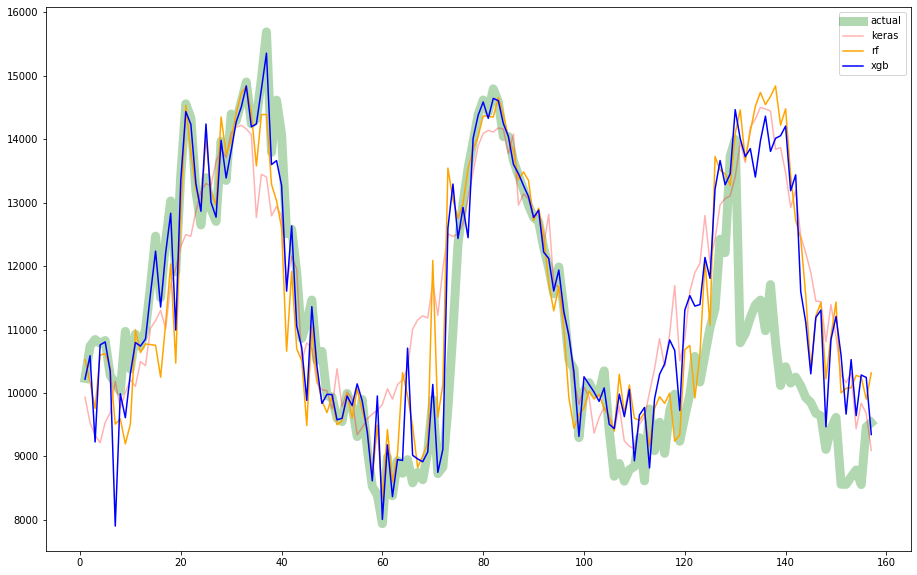

In [51]:
df_graph = result_df.copy()
plt.figure(figsize=(15.5, 10))
plt.plot(df_graph.week,df_graph.qty, ls='-', label='actual', color='green', alpha=0.3, lw=9)
plt.plot(df_graph.week,df_graph.keras_qty, ls='-', label='keras', color='r', alpha=0.3)
plt.plot(df_graph.week,df_graph.rf_qty, ls='-', label='rf', color='orange')
plt.plot(df_graph.week,df_graph.xgb_qty, ls='-', label='xgb', color='b')
plt.legend()
plt.show()

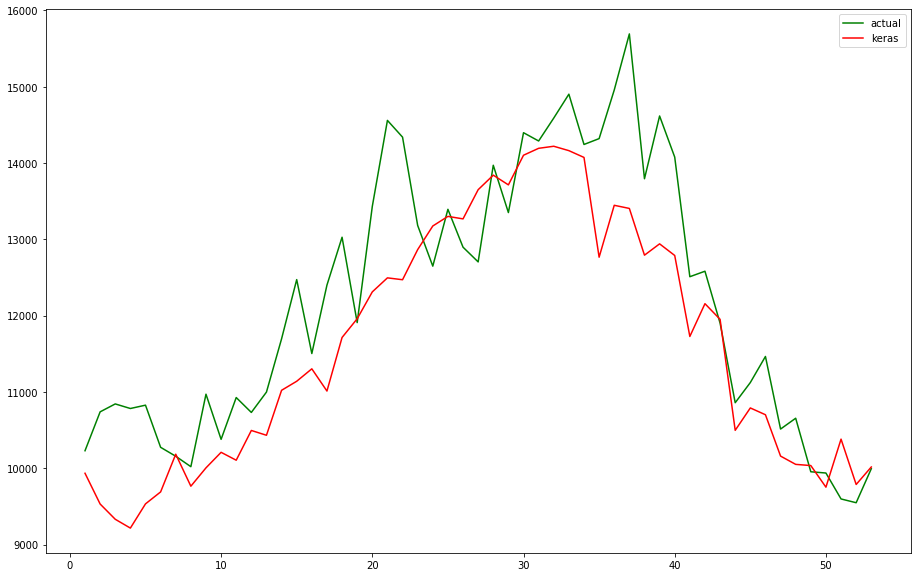

In [44]:
df_graph = result_df.loc[result_df.week <=53]
plt.figure(figsize=(15.5, 10))
plt.plot(df_graph.week,df_graph.qty, ls='-', label='actual', color='green')
plt.plot(df_graph.week,df_graph.keras_qty, ls='-', label='keras', color='r')
# plt.plot(df_graph.week,df_graph.rf_qty, ls='--', label='rf', color='cyan')
# plt.plot(df_graph.week,df_graph.xgb_qty, ls='--', label='xgb', color='b')
plt.legend()
plt.show()

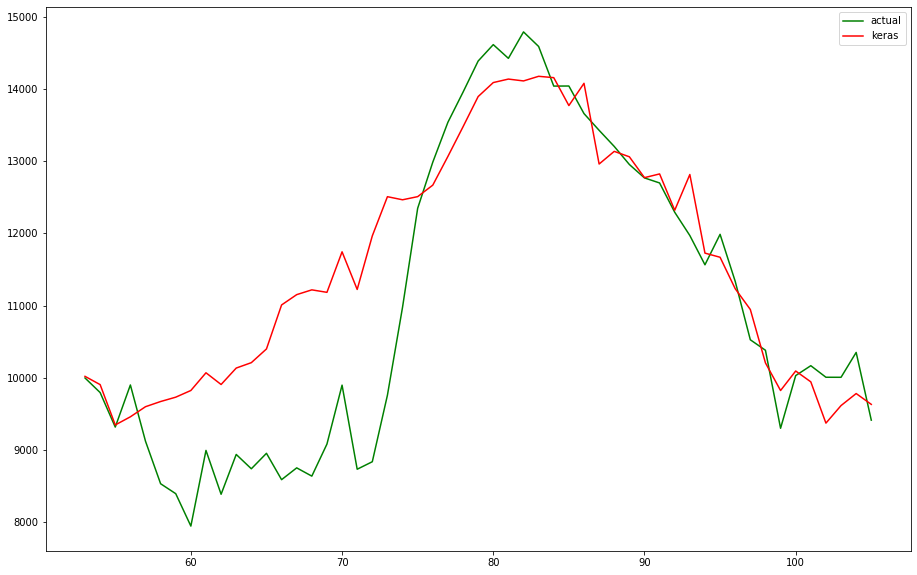

In [45]:
df_graph = result_df.loc[(result_df.week >=53)&(result_df.week <=105)]
plt.figure(figsize=(15.5, 10))
plt.plot(df_graph.week,df_graph.qty, ls='-', label='actual', color='green')
plt.plot(df_graph.week,df_graph.keras_qty, ls='-', label='keras', color='r')
# plt.plot(df_graph.week,df_graph.rf_qty, ls='--', label='rf', color='cyan')
# plt.plot(df_graph.week,df_graph.xgb_qty, ls='--', label='xgb', color='b')
plt.legend()
plt.show()

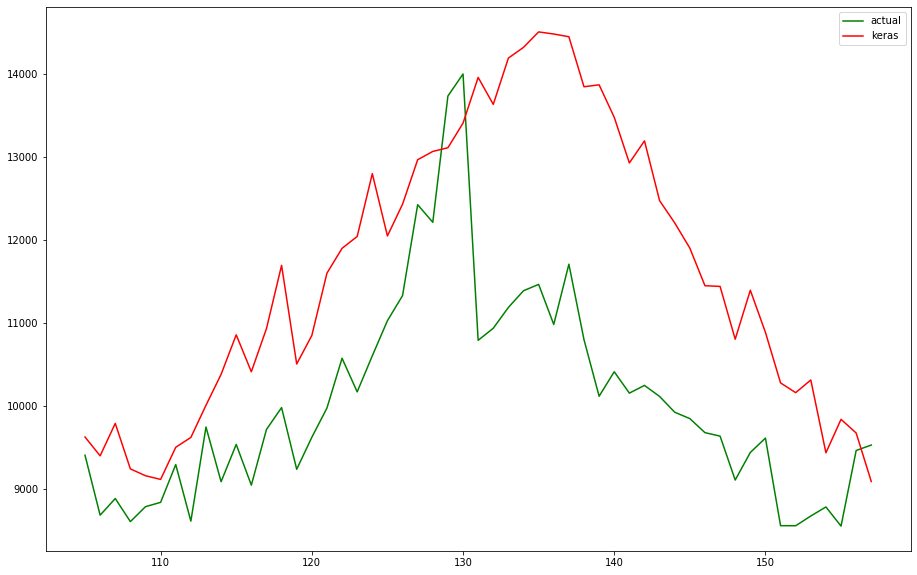

In [47]:
df_graph = result_df.loc[(result_df.week >=105)]
plt.figure(figsize=(15.5, 10))
plt.plot(df_graph.week,df_graph.qty, ls='-', label='actual', color='green')
plt.plot(df_graph.week,df_graph.keras_qty, ls='-', label='keras', color='r')
# plt.plot(df_graph.week,df_graph.rf_qty, ls='--', label='rf', color='cyan')
# plt.plot(df_graph.week,df_graph.xgb_qty, ls='--', label='xgb', color='b')
plt.legend()
plt.show()

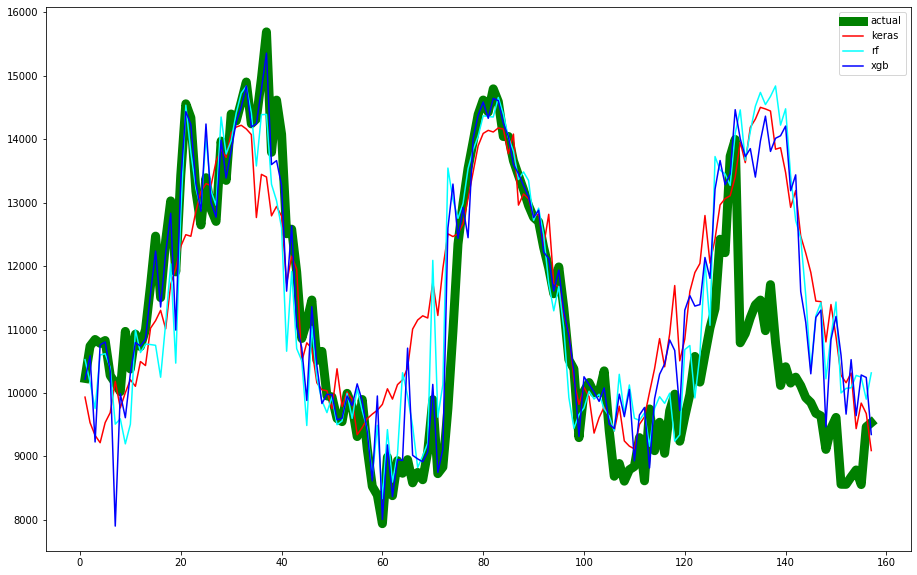

In [49]:
df_graph = result_df
plt.figure(figsize=(15.5, 10))
plt.plot(df_graph.week,df_graph.qty, ls='-', label='actual', color='green', lw=9)
plt.plot(df_graph.week,df_graph.keras_qty, ls='-', label='keras', color='r')
plt.plot(df_graph.week,df_graph.rf_qty, ls='-', label='rf', color='cyan')
plt.plot(df_graph.week,df_graph.xgb_qty, ls='-', label='xgb', color='b')
plt.legend()
plt.show()

In [34]:
orginal_mean = np.mean(result_df.qty)
result_df['qtyMinusMean'] = (result_df.qty - orginal_mean )
result_df['qtyMinusMeanSquared'] = (result_df.qty - orginal_mean )**2

result_df['kerasMiunsMeanSquared'] = (result_df.keras_qty - orginal_mean)**2
result_df['rfMiunsMeanSquared'] = (result_df.rf_qty - orginal_mean)**2
result_df['xgbMiunsMeanSquared'] = (result_df.xgb_qty - orginal_mean)**2

print('kreas R-sq',(sum(result_df['kerasMiunsMeanSquared']) / sum(result_df['qtyMinusMeanSquared'])))
print('rf R-sq',(sum(result_df['rfMiunsMeanSquared']) / sum(result_df['qtyMinusMeanSquared'])))
print('xgb R-sq',(sum(result_df['xgbMiunsMeanSquared']) / sum(result_df['qtyMinusMeanSquared'])))

kreas R-sq 0.7716694476827852
rf R-sq 1.0154626931859514
xgb R-sq 1.012190919824269


In [36]:
path = 'D:/project/contest/data/result/'
result_df.to_csv(path+item+'_'+grouped_by+'_predict.csv', encoding='utf-8', index=False)

In [50]:
plt.legend?